In [16]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

### Instructions

Your case study is to build a classifier using logistic regression to predict hospital readmittance. 
There is missing data that must be imputed. Once again, discuss variable importances as part of your submission.

### Team:
- Dylan Scott
- Jobin Joseph
- Taylor Bonar
- Satvik Ajmera

In [17]:
#data
diabetes_df = pd.read_csv("../dataset_diabetes/diabetic_data.csv", header=0, na_values="?", low_memory=False)
diabetes_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [18]:
diabetes_df['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [19]:
diabetes_df['age'].value_counts()

[70-80)     26068
[60-70)     22483
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [20]:
age_values = list(diabetes_df['age'].unique())

In [21]:
diabetes_df['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [22]:
#value dictionaries
Race = {'Caucasian':0, 'AfricanAmerican':1, 'Hispanic':2,'Other':3,'Asian':4, np.nan:5}
Gender = {'Male': 1,'Female': 0,'Unknown/Invalid':3}
Age = {}
count = 0
for i in range(len(age_values)):
    Age[age_values[i]] = count
    count+=1

diabetes_df.race = [Race[item] for item in diabetes_df.race]
diabetes_df.gender = [Gender[item] for item in diabetes_df.gender]
diabetes_df.age = [Age[item] for item in diabetes_df.age]
diabetes_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,0,0,0,NaN,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,0,0,1,NaN,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,1,0,2,NaN,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,0,1,3,NaN,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,0,1,4,NaN,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


<function matplotlib.pyplot.show(close=None, block=None)>

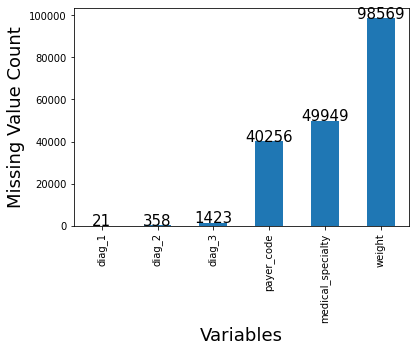

<Figure size 720x1800 with 0 Axes>

In [23]:

#iterate though all the columns and show all the possible vaules 
#next make sure to actually swap out the values
#but first lets look at missing values
missing = diabetes_df.isna().sum()
missing = pd.DataFrame(missing, columns = ['missing'])
missing = missing[(missing.T !=0).any()]
missing = missing.sort_values('missing')

missing.plot(kind = 'bar', legend = False)
plt.ylabel('Missing Value Count', fontsize=18)
plt.xlabel('Variables', fontsize=18)
plt.xticks(rotation='90')
for index,data in enumerate(missing['missing']):
    plt.text(x=index , y =data+2 , s=f"{data}" , fontdict=dict(fontsize=15), ha='center')
plt.figure(figsize=(10, 25))
plt.show

In [24]:
#per the profs recc we should drop wight since it is missing for more than half the dataset
#drop weight, payer code and medical spec
diabetes_df = diabetes_df.drop(columns=['weight','payer_code','medical_specialty'])
#diabetes_df = diabetes_df.drop(columns=['encounter_id','patient_nbr'])
diabetes_df = diabetes_df.drop(columns=['encounter_id'])
#diabetes_df = diabetes_df.drop(columns=['diag_1','diag_2','diag_3'])
diabetes_df = diabetes_df.loc[~diabetes_df.discharge_disposition_id.isin([11,13,14,19,20,21])]
readmitted = {'<30':1,'NO':0,'>30':2}
diabetes_df.readmitted = [readmitted[item] for item in diabetes_df.readmitted]
diabetes_df = diabetes_df.drop_duplicates(keep="last",subset="patient_nbr")
diabetes_df = diabetes_df.dropna()
#should we fill in the unknown race?
diabetes_df['race'].fillna('Caucasian')
final_df = diabetes_df.drop(columns = ["patient_nbr"])
final_df.head(1)

,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
1,0,0,1,1,1,7,3,59,0,18,...,No,Up,No,No,No,No,No,Ch,Yes,2


In [25]:

final_df.isna().sum()


race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide

In [26]:
#pd get dummies

#number cols
numeric_features = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']
#categorical vars
categorical_features = ['race', 'gender', 
       'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']


In [27]:
X = diabetes_df.drop(columns=['readmitted']).copy()
y = diabetes_df['readmitted'].values.copy()
#X = pd.get_dummies(X)

In [28]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler(with_mean=False))])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop="first"))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_scaled = pipeline.fit_transform(X)

In [43]:
# X= X.values
# y= y.values
np.bincount(y)

array([51034,  3446, 14303], dtype=int64)

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit 
sss_cv = StratifiedShuffleSplit(n_splits=5,test_size=0.20, random_state=42)

In [33]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
import time

lr_clf = LogisticRegression(multi_class = "multinomial",max_iter=5000, random_state=42)

iter_num=0

for train_indices, test_indices in sss_cv.split(X_scaled,y): 
    X_train = X_scaled[train_indices]
    y_train = y[train_indices]
    
    X_test = X_scaled[test_indices]
    y_test = y[test_indices]
    lr_clf.fit(X_train,y_train)  # train object

    y_hat = lr_clf.predict(X_test) # get test set predictions
    print("====Iteration",iter_num," ====")
    acc = mt.accuracy_score(y_test,y_hat)
    print('Accuracy:', acc)
    iter_num+=1

====Iteration 0  ====
Accuracy: 0.7418768626880861
====Iteration 1  ====
Accuracy: 0.7409318892200334
====Iteration 2  ====
Accuracy: 0.7450025441593371
====Iteration 3  ====
Accuracy: 0.7415134113542197
====Iteration 4  ====
Accuracy: 0.7416587918877662
CPU times: total: 8min 18s
Wall time: 2min 59s


In [35]:
%%time
from sklearn.model_selection import GridSearchCV
regEstimator = LogisticRegression(multi_class = "multinomial")

parameters = { 'penalty':['l1','l2']
              ,'C': [0.001, 0.01, 0.1]
              ,'random_state': [42]
              ,'solver': ['saga']
              ,'max_iter':[5000]
             }


GridSearch = GridSearchCV(estimator=regEstimator
                   , verbose=3
                   , param_grid=parameters
                   , cv=sss_cv 
                   , scoring='accuracy')

GridSearch.fit(X_scaled, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END C=0.001, max_iter=5000, penalty=l1, random_state=42, solver=saga;, score=0.743 total time=   3.8s
[CV 2/5] END C=0.001, max_iter=5000, penalty=l1, random_state=42, solver=saga;, score=0.741 total time=   5.3s
[CV 3/5] END C=0.001, max_iter=5000, penalty=l1, random_state=42, solver=saga;, score=0.743 total time=   5.4s
[CV 4/5] END C=0.001, max_iter=5000, penalty=l1, random_state=42, solver=saga;, score=0.741 total time=   3.6s
[CV 5/5] END C=0.001, max_iter=5000, penalty=l1, random_state=42, solver=saga;, score=0.742 total time=   3.5s
[CV 1/5] END C=0.001, max_iter=5000, penalty=l2, random_state=42, solver=saga;, score=0.742 total time=  24.4s
[CV 2/5] END C=0.001, max_iter=5000, penalty=l2, random_state=42, solver=saga;, score=0.742 total time=  35.8s
[CV 3/5] END C=0.001, max_iter=5000, penalty=l2, random_state=42, solver=saga;, score=0.744 total time=  37.1s
[CV 4/5] END C=0.001, max_iter=5000, penalty=l2, ran

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
             estimator=LogisticRegression(multi_class='multinomial'),
             param_grid={'C': [0.001, 0.01, 0.1], 'max_iter': [5000],
                         'penalty': ['l1', 'l2'], 'random_state': [42],
                         'solver': ['saga']},
             scoring='accuracy', verbose=3)

In [36]:
lr_best_est = GridSearch.best_estimator_
#lr_best_est = LogisticRegression(C=0.001, max_iter=5000, multi_class='multinomial',
#                   random_state=42, solver='saga',, penalty=l2)
#END C=0.01, max_iter=5000, penalty=l2, random_state=42, solver=saga;, score=0.745 total time= 3.2min
#{'C': 0.001, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}
#END C=0.1, max_iter=5000, penalty=l1, random_state=42, solver=saga;, score=0.745 total time= 5.0min
print(lr_best_est)

LogisticRegression(C=0.001, max_iter=5000, multi_class='multinomial',
                   random_state=42, solver='saga')


In [37]:
print('Highest Accuracy', GridSearch.best_score_ )

Highest Accuracy 0.7422403140219525


In [40]:
best_params = GridSearch.best_params_
print(best_params)

{'C': 0.001, 'max_iter': 5000, 'penalty': 'l2', 'random_state': 42, 'solver': 'saga'}


In [38]:
from sklearn.model_selection import cross_val_predict
pred = cross_val_predict(lr_best_est,X_test,y_test, cv=5)

<function matplotlib.pyplot.show(close=None, block=None)>

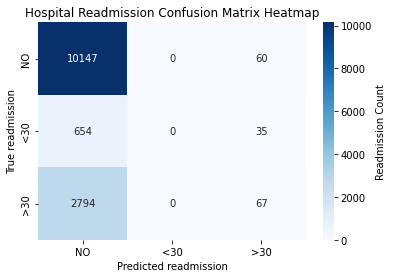

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,pred)
x_axis_labels = ['NO','<30', '>30']
y_axis_labels = ['NO','<30', '>30']
ax = plt.axes()
sns.heatmap(cm, cmap='Blues', annot=True, fmt='d',xticklabels=x_axis_labels,
            yticklabels=y_axis_labels, ax=ax, cbar_kws={'label': 'Readmission Count',})
ax.set_title('Hospital Readmission Confusion Matrix Heatmap')
plt.xlabel("Predicted readmission")
plt.ylabel("True readmission") 
plt.show

In [48]:
final_mod = lr_best_est.fit(X_train,y_train)
final_mod.score(X_test,y_test)

0.7416587918877662

In [60]:
feature_names = pd.DataFrame(X_scaled)
feature_names = feature_names.columns.values
feature_importances = pd.DataFrame(final_mod.coef_[0],
                                   index = feature_names,
                                  columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [61]:
feature_importances

,importance
8,0.133026
12,0.043348
37,0.038241
60,0.034325
22,0.033054
...,...
5,-0.069248
68,-0.104100
1,-0.119639
7,-0.125773
